# Modeling and Simulation in Python

Rabbit example

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [2]:
# If you want the figures to appear in the notebook, 
# and you want to interact with them, use
# %matplotlib notebook

# If you want the figures to appear in the notebook, 
# and you don't want to interact with them, use
# %matplotlib inline

# If you want the figures to appear in separate windows, use
# %matplotlib qt5

# To switch from one to another, you have to select Kernel->Restart

%matplotlib inline

from modsim import *

help(TimeSeries)

Help on class TimeSeries in module modsim:

class TimeSeries(MySeries)
 |  One-dimensional ndarray with axis labels (including time series).
 |  
 |  Labels need not be unique but must be a hashable type. The object
 |  supports both integer- and label-based indexing and provides a host of
 |  methods for performing operations involving the index. Statistical
 |  methods from ndarray have been overridden to automatically exclude
 |  missing data (currently represented as NaN).
 |  
 |  Operations between Series (+, -, /, *, **) align values based on their
 |  associated index values-- they need not be the same length. The result
 |  index will be the sorted union of the two indexes.
 |  
 |  Parameters
 |  ----------
 |  data : array-like, dict, or scalar value
 |      Contains data stored in Series
 |  index : array-like or Index (1d)
 |      Values must be hashable and have the same length as `data`.
 |      Non-unique index values are allowed. Will default to
 |      RangeIndex(len(

This notebook develops a simple growth model, like the ones in Chapter 3, and uses it to demonstrate a parameter sweep.

The system we'll model is a rabbit farm.  Suppose you start with an initial population of rabbits and let them breed.  For simplicity, we'll assume that all rabbits are on the same breeding cycle, and we'll measure time in "seasons", where a season is the reproductive time of a rabbit.

If we provide all the food, space and other resources a rabbit might need, we expect the number of new rabbits each season to be proportional to the current population, controlled by a parameter, `birth_rate`, that represents the number of new rabbits per existing rabbit, per season.  As a starting place, I'll assume `birth_rate = 0.9`.

Sadly, during each season, some proportion of the rabbits die.  In a detailed model, we might keep track of each rabbit's age, because the chance of dying is probably highest for young and old rabbits, and lowest in between.  But for simplicity, we'll model the death process with a single parameter, `death_rate`, that represent the number
of deaths per rabbit per season.   As a starting place, I'll assume `death_rate = 0.5`.

Here's a system object that contains these parameters as well as:

* The initial population, `p0`,
* The initial time, `t0`, and
* The duration of the simulation, `t_end`, measured in seasons.

In [2]:
system = System(t0 = 0, 
                t_end = 10,
                p0 = 10,
                birth_rate = 0.9,
                death_rate = 0.5)

system

,value
t0,0.0
t_end,10.0
p0,10.0
birth_rate,0.9
death_rate,0.5


Here's a version of run_simulation, similar to the one in Chapter 3, with both births and deaths proportional to the current population.

In [3]:
def run_simulation(system):
    """Runs a proportional growth model.
    
    Adds TimeSeries to `system` as `results`.
    
    system: System object with t0, t_end, p0,
            birth_rate and death_rate
    """
    results = TimeSeries()
    results[system.t0] = system.p0
    for t in linrange(system.t0, system.t_end):
        births = system.birth_rate * results[t]
        deaths = system.death_rate * results[t]
        results[t+1] = results[t] + births - deaths
    system.results = results

Now we can run the simulation and display the results:

In [4]:
run_simulation(system)
system.results

,value
0,10.000000
1,14.000000
2,19.600000
3,27.440000
4,38.416000
5,53.782400
6,75.295360
7,105.413504
8,147.578906
9,206.610468


Notice that the simulation actually runs one season past `t_end`.  That's an off-by-one error that I'll fix later, but for now we don't really care.

The following function plots the results.

In [5]:
def plot_results(system, title=None):
    """Plot the estimates and the model.
    
    system: System object with `results`
    """
    newfig()
    plot(system.results, 'bo', label='rabbits')
    decorate(xlabel='Season', 
             ylabel='Rabbit population',
             title=title)

And here's how we call it.

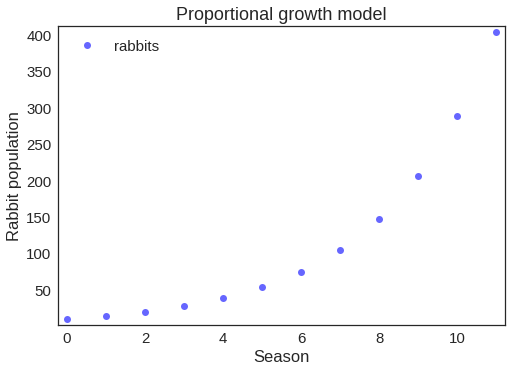

In [6]:
plot_results(system, title='Proportional growth model')

Let's suppose our goal is to maximize the number of rabbits, so the metric we care about is the final population.  We can extract it from the results like this:

In [7]:
def final_population(system):
    t_end = system.results.index[-1]
    return system.results[t_end]

And call it like this:

In [8]:
final_population(system)

404.95651696640027

To explore the effect of the parameters on the results, we'll define `make_system`, which takes the system parameters as function parameters(!) and returns a `System` object:

In [9]:
def make_system(birth_rate=0.9, death_rate=0.5):
    
    system = System(t0 = 0, 
                    t_end = 10,
                    p0 = 10,
                    birth_rate = birth_rate,
                    death_rate = death_rate)
    return system

Now we can make a `System`, run a simulation, and extract a metric:

In [10]:
system = make_system()
run_simulation(system)
final_population(system)

404.95651696640027

To see the relationship between `birth_rate` and final population, we'll define `sweep_birth_rate`:

In [11]:
def sweep_birth_rate(birth_rates, death_rate=0.5):
    
    for birth_rate in birth_rates:
        system = make_system(birth_rate=birth_rate,
                             death_rate=death_rate)
        run_simulation(system)
        p_end = final_population(system)
        plot(birth_rate, p_end, 'gs', label='rabbits')
        
    decorate(xlabel='Births per rabbit per season',
             ylabel='Final population')

The first parameter of `sweep_birth_rate` is supposed to be an array; we can use `linspace` to make one.

In [12]:
birth_rates = linspace(0, 1, 21)
birth_rates

array([ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,
        0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,
        0.9 ,  0.95,  1.  ])

Now we can call `sweep_birth_rate`.

The resulting figure shows the final population for a range of values of `birth_rate`.

Confusingly, the results from a parameter sweep sometimes resemble a time series.  It is very important to remember the difference.  One way to avoid confusion: LABEL THE AXES.

In the following figure, the x-axis is `birth_rate`, NOT TIME.

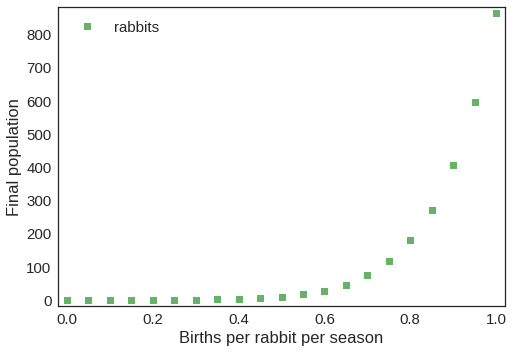

In [13]:
birth_rates = linspace(0, 1, 21)
sweep_birth_rate(birth_rates)

The code to sweep the death rate is similar.

In [14]:
def sweep_death_rate(death_rates, birth_rate=0.9):
    
    for death_rate in death_rates:
        system = make_system(birth_rate=birth_rate,
                             death_rate=death_rate)
        run_simulation(system)
        p_end = final_population(system)
        plot(death_rate, p_end, 'r^', label='rabbits')
        
    decorate(xlabel='Deaths per rabbit per season',
             ylabel='Final population')

And here are the results.  Again, the x-axis is `death_rate`, NOT TIME.

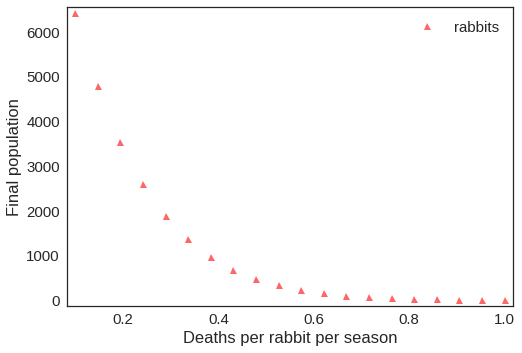

In [15]:
death_rates = linspace(0.1, 1, 20)
sweep_death_rate(death_rates)

In the previous sweeps, we hold one parameter constant and sweep the other.

You can also sweep more than one variable at a time, and plot multiple lines on a single axis.

To keep the figure from getting too cluttered, I'll reduce the number of values in `birth_rates`:

In [16]:
birth_rates = linspace(0.4, 1, 4)
birth_rates

array([ 0.4,  0.6,  0.8,  1. ])

By putting one for loop inside another, we can enumerate all pairs of values.

The results show 4 lines, one for each value of `birth_rate`.

(I did not plot the lines between the data points because of a limitation in `plot`.)

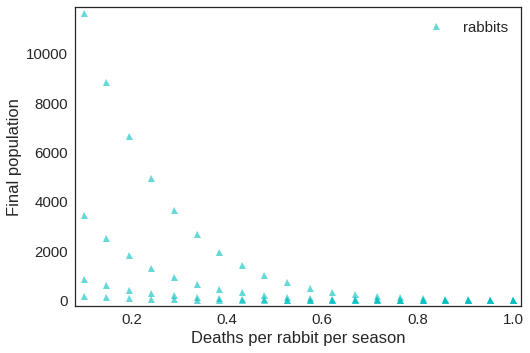

In [17]:
for birth_rate in birth_rates:
    for death_rate in death_rates:
        system = make_system(birth_rate=birth_rate,
                             death_rate=death_rate)
        run_simulation(system)
        p_end = final_population(system)
        plot(death_rate, p_end, 'c^', label='rabbits')
        
decorate(xlabel='Deaths per rabbit per season',
         ylabel='Final population')

If you suspect that the results depend on the difference between `birth_rate` and `death_rate`, you could run the same loop, plotting the "net birth rate" on the x axis.

If you are right, the results will fall on a single curve, which means that knowing the difference is sufficient to predict the outcome; you don't actually have to know the two parameters separately.

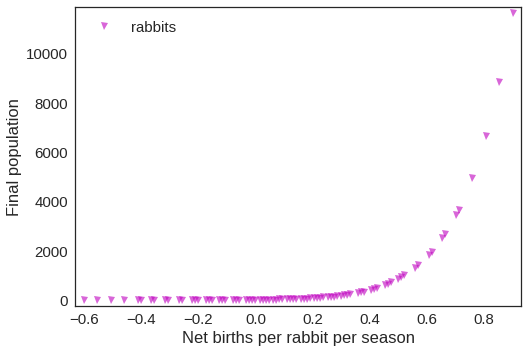

In [18]:
for birth_rate in birth_rates:
    for death_rate in death_rates:
        system = make_system(birth_rate=birth_rate,
                             death_rate=death_rate)
        run_simulation(system)
        p_end = final_population(system)
        net_birth_rate = birth_rate - death_rate
        plot(net_birth_rate, p_end, 'mv', label='rabbits')
        
decorate(xlabel='Net births per rabbit per season',
         ylabel='Final population')

On the other hand, if you guess that the results depend on the ratio of the parameters, rather than the difference, you could check by plotting the ratio on the x axis.

If the results don't fall on a single curve, that suggests that the ratio alone is not sufficient to predict the outcome. 

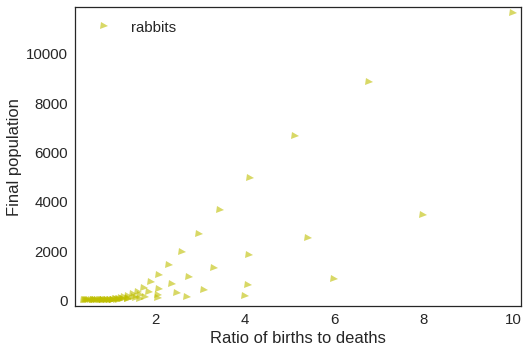

In [19]:
for birth_rate in birth_rates:
    for death_rate in death_rates:
        system = make_system(birth_rate=birth_rate,
                             death_rate=death_rate)
        run_simulation(system)
        p_end = final_population(system)
        birth_ratio = birth_rate / death_rate
        plot(birth_ratio, p_end, 'y>', label='rabbits')
        
decorate(xlabel='Ratio of births to deaths',
         ylabel='Final population')